In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import numpy as np
sys.path.append("../..")

from xlstm_scaling_laws.analysis.fit_inference_time_model.objective_funcs import (
    InferenceModelObjectiveConfig,
    get_inference_time_model_objective_func,
)
from xlstm_scaling_laws.load_data.inference_time import load_inference_time_data
from xlstm_scaling_laws.fitting.common.run_fit import run_optimization, OptimizationConfig
from xlstm_scaling_laws.fitting.common.initialization import generate_initialization_sweep
from xlstm_scaling_laws.model_accounting.inference_time_model.mlstm_runtime_model import (
    predict_runtime_mlstm_step_time
)
import matplotlib.pyplot as plt
import seaborn as sns

# Fit the data of one model size and one batch size

This works for the simple linear_flops and linear_memops params.


In [2]:
ttft_df, step_time_df = load_inference_time_data("xlstm")

In [3]:
step_time_df

model             input_params         measured_data  \
    model_type   model_tag    batchsize prefill    num_params   
0        xlstm  xlstm_160m            1       0     162340752   
1        xlstm  xlstm_160m            1     128     162340752   
2        xlstm  xlstm_160m            1     256     162340752   
3        xlstm  xlstm_160m            1     512     162340752   
4        xlstm  xlstm_160m            1    1024     162340752   
..         ...         ...          ...     ...           ...   
775      xlstm    xlstm_7b         1024    2048    6865424896   
776      xlstm    xlstm_7b         1024    4096    6865424896   
777      xlstm    xlstm_7b         1024    8192    6865424896   
778      xlstm    xlstm_7b         1024   12288    6865424896   
779      xlstm    xlstm_7b         1024   16384    6865424896   

                                                                     \
    memory_allocated_gl1 memory_reserved_gl1 memory_allocated_gl101   
0              651337216           679477248             1658011136   
1              684892672           790626304             1658012160   
2              718448640           912261120             1658013696   
3              752005632          1086324736             1658016256   
4              785564672          1405091840             1658020864   
..                   ...                 ...                    ...   
775                   -1                  -1                     -1   
776                   -1                  -1                     -1   
777                   -1                  -1                     -1   
778                   -1                  -1                     -1   
779                   -1                  -1                     -1   

                          model_params                                         \
    memory_reserved_gl101    num_heads embedding_dim num_blocks qk_dim_factor   
0              1749024768          6.0         768.0       12.0           0.5   
1              1824522240          6.0         768.0       12.0           0.5   
2              1910505472          6.0         768.0       12.0           0.5   
3              2048917504          6.0         768.0       12.0           0.5   
4              2332033024          6.0         768.0       12.0           0.5   
..                    ...          ...           ...        ...           ...   
775                    -1          8.0        4096.0       32.0           0.5   
776                    -1          8.0        4096.0       32.0           0.5   
777                    -1          8.0        4096.0       32.0           0.5   
778                    -1          8.0        4096.0       32.0           0.5   
779                    -1          8.0        4096.0       32.0           0.5   

                                                                       \
    ffn_proj_factor ffn_round_up_to_multiple_of vocab_size chunk_size   
0            2.6667                        64.0    50304.0      128.0   
1            2.6667                        64.0    50304.0      128.0   
2            2.6667                        64.0    50304.0      128.0   
3            2.6667                        64.0    50304.0      128.0   
4            2.6667                        64.0    50304.0      128.0   
..              ...                         ...        ...        ...   
775          2.6667                        64.0    50304.0      128.0   
776          2.6667                        64.0    50304.0      128.0   
777          2.6667                        64.0    50304.0      128.0   
778          2.6667                        64.0    50304.0      128.0   
779          2.6667                        64.0    50304.0      128.0   

             measured_data  
     ffn_dim       runtime  
0     2112.0       0.71673  
1     2112.0      0.715802  
2     2112.0      0.716002  
3     2112.0      0.715633  
4     2112.0      0.715953  
..       ...           ...  
775

In [4]:
step_time_df[('model', 'model_tag')].unique()

array(['xlstm_160m', 'xlstm_400m', 'xlstm_830m', 'xlstm_1.4b',
       'xlstm_2.7b', 'xlstm_7b'], dtype=object)

In [5]:
model = "xlstm_400m"
df = step_time_df.dropna()
df = df[df[("input_params", "prefill")] != 0][df[("model", "model_tag")] == model][df[("input_params", "batchsize")] >= 8]
data_df = df.copy()

/tmp/ipykernel_197389/2596172142.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df[("input_params", "prefill")] != 0][df[("model", "model_tag")] == model][df[("input_params", "batchsize")] >= 8]
/tmp/ipykernel_197389/2596172142.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df[("input_params", "prefill")] != 0][df[("model", "model_tag")] == model][df[("input_params", "batchsize")] >= 8]


In [6]:
data_df

model             input_params         measured_data  \
    model_type   model_tag    batchsize prefill    num_params   
161      xlstm  xlstm_400m            8     128     406856896   
162      xlstm  xlstm_400m            8     256     406856896   
163      xlstm  xlstm_400m            8     512     406856896   
164      xlstm  xlstm_400m            8    1024     406856896   
165      xlstm  xlstm_400m            8    2048     406856896   
166      xlstm  xlstm_400m            8    4096     406856896   
167      xlstm  xlstm_400m            8    8192     406856896   
171      xlstm  xlstm_400m           16     128     406856896   
172      xlstm  xlstm_400m           16     256     406856896   
173      xlstm  xlstm_400m           16     512     406856896   
174      xlstm  xlstm_400m           16    1024     406856896   
175      xlstm  xlstm_400m           16    2048     406856896   
176      xlstm  xlstm_400m           16    4096     406856896   
181      xlstm  xlstm_400m           32     128     406856896   
182      xlstm  xlstm_400m           32     256     406856896   
183      xlstm  xlstm_400m           32     512     406856896   
184      xlstm  xlstm_400m           32    1024     406856896   
185      xlstm  xlstm_400m           32    2048     406856896   
191      xlstm  xlstm_400m           64     128     406856896   
192      xlstm  xlstm_400m           64     256     406856896   
193      xlstm  xlstm_400m           64     512     406856896   
194      xlstm  xlstm_400m           64    1024     406856896   
201      xlstm  xlstm_400m          128     128     406856896   
202      xlstm  xlstm_400m          128     256     406856896   
203      xlstm  xlstm_400m          128     512     406856896   
211      xlstm  xlstm_400m          256     128     406856896   
212      xlstm  xlstm_400m          256     256     406856896   
221      xlstm  xlstm_400m          384     128     406856896   
231      xlstm  xlstm_400m          512     128     406856896   
241      xlstm  xlstm_400m          768     128     406856896   

                                                                     \
    memory_allocated_gl1 memory_reserved_gl1 memory_allocated_gl101   
161           2143493120          3074424832             2147466240   
162           2143501824          3684696064             2147474944   
163           2143518720          5012193280             2147491840   
164           2143552000          7606370304             2147525120   
165           2143618048         12838764544             2147591168   
166           2143749632         23324524544             2147722752   
167           2144012288         44247810048             2147985408   
171           2143506432          3783262208             2147479552   
172           2143523328          5114953728             2147496448   
173           2143556608          7709130752             2147529728   
174           2143622656         12941524992             2147595776   
175           2143754240         23425187840             2147727360   
176           2144016896         44348473344             2147990016   
181           2143526912          5295308800             2147500032   
182           2143560192          7910457344             2147533312   
183           2143626240         13159628800             2147599360   
184           2143757824         23628611584             2147730944   
185           2144020480         44551897088             2147993600   
191           2143563264          8313110528             2147536384   
192           2143629312         13541310464             2147602432   
193           2143760896         24024973312             2147734016   
194           2144023552         44973424640             2147996672   
201           2143631872         14350811136             2147604992   
202           2143763456         24823988224             2147736576   
203           2144026112         45793411072             2147999232   
211        

In [7]:
optim_cfg = OptimizationConfig(
    objective_func_config=InferenceModelObjectiveConfig(
        huber_delta=100.,
        filter_zero_prefill=True,
        fit_data="step_time",
        fit_model="xlstm",
        runtime_model_mode="log_linear_memops", #"linear_sum_flops_memops", #"linear_flops",
        factor_causal=0.75,
        bytes_act=2,
        bytes_Cmn=4,
        bytes_w=2,
        override_df=data_df[df[("input_params", "batchsize")] > 1],
        reduce_loss="none",
        squeeze_loos=True,  # Squeeze the loss to avoid issues with broadcasting
    ),
    scipy_optim_module="least_squares",
    method="lm",
    bootstrap_seed=0,
    num_bootstrap_samples=-1,
    # initialization_grid={
    #     "alpha": [900e12],
    #     "beta": [3.35e13],
    #     "rho": [1e-14],
    # },
    initialization_grid={
        # "alpha": [np.log(0.45 * 900e12)],
        # "alpha": [0.9 * 900e12],
        "beta": [1.5 * 3.35e12],
        "eps": [1e-4],#[2e-3],
        "eps_bp": [0],#[2e-3],

        # "beta": [np.log(1.5 * 3.35e13)],
        # "rho": [np.log(1e-14)],
    },
    tol=1e-15,
    other_optimization_kwargs=dict(
        xtol=1e-15,
        gtol=1e-15,
        # ftol=1e-14,
    )
)
print(optim_cfg.initialization_grid)

{'beta': [5025000000000.0], 'eps': [0.0001], 'eps_bp': [0]}


In [8]:
optim_res_df = run_optimization(
    config=optim_cfg,
    objective_func_generator=get_inference_time_model_objective_func,
)

Running optimization: 100%|██████████| 1/1 [00:07<00:00,  7.27s/it]


In [9]:
optim_res_df.T

0
idxes         init_idx                                                       0
              bootstrap_idx                                                  0
optim_params  beta                                      -59109707009603.507812
              eps                                                     0.001866
              eps_bp                                                  0.000011
optim_results loss           [0.0002635620392372919, 2.670884489031221e-05,...
              message               `xtol` termination condition is satisfied.
              success                                                     True
              jac            [[-1.0868292858316735e-17, 5.040092350470051, ...
              nfev                                                         135
              njev                                                        None
              status                                                         3
init_params   beta                                             5025000000000.0
              eps                                                       0.0001
              eps_bp                                                       0.0

In [10]:
opt_params = optim_res_df.iloc[0, :]["optim_params"].to_dict()
# if optim_cfg.objective_func_config.runtime_model_mode.startswith("log_"):
#     opt_params = {k: float(np.exp(v)) for k, v in opt_params.items()}
print(opt_params)

{'beta': -59109707009603.51, 'eps': 0.001865982143832099, 'eps_bp': 1.1002393049464716e-05}


In [11]:
# opt_params = {
#     "beta": 0.1 * 3.35e13,
#     "eps": 2e-3,
# }
# opt_params

In [12]:
pred_step_time_df = predict_runtime_mlstm_step_time(
    step_time_df=data_df.iloc[:, :],
    **opt_params,
    mode="linear_memops",
)

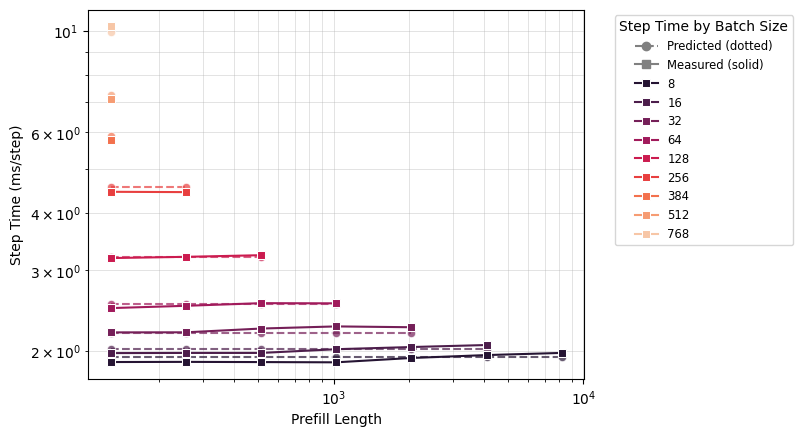

In [13]:
df = pred_step_time_df.copy()
# bs = 8
# df = df[df[("input_params", "batchsize")] == bs]

df = df[df[("model", "model_tag")] == model][df[("input_params", "batchsize")] < 2000]#[df[("input_params", "batchsize")] > 1]
df[("input_params", "batchsize")] = df[("input_params", "batchsize")].astype(str)
df[("pred", "runtime")] = df[("pred", "runtime")]
# ax = sns.lineplot(df, x=("input_params", "prefill"), y=('predicted_data', 'pred'), hue=("model", "model_tag"), markers=True, dashes=False)
ax = sns.lineplot(
    df,
    x=("input_params", "prefill"),
    y=("pred", "runtime"),
    hue=("input_params", "batchsize"),
    markers=True,
    dashes=False,
    marker="o",
    linestyle="--",
    alpha=0.7,
    palette="rocket",
    legend=False,
)
ax = sns.lineplot(
    df,
    x=("input_params", "prefill"),
    y=("measured_data", "runtime"),
    hue=("input_params", "batchsize"),
    markers=True,
    dashes=False,
    marker="s",
    legend="auto",
    palette="rocket",
)
ax.set_ylabel("Step Time (ms/step)")
ax.set_xlabel("Prefill Length")
# # ax = sns.lineplot(df, x=("input_params", "prefill"), y=('measured_data', 'runtime'), hue=('measured_data', 'num_params'), markers=True, dashes=False)
# Custom legend handles
import matplotlib.lines as mlines

dotted_line = mlines.Line2D(
    [], [], color="gray", linestyle="--", marker="o", label="Predicted (dotted)"
)
solid_line = mlines.Line2D(
    [], [], color="gray", linestyle="-", marker="s", label="Measured (solid)"
)
# header

# Existing legend handles (for batchsize)
handles, labels = ax.get_legend_handles_labels()

# Combine custom and existing handles
custom_handles = [dotted_line, solid_line]
ax.legend(
    custom_handles + handles,
    ["Predicted (dotted)", "Measured (solid)"] + labels,
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    title="Step Time by Batch Size",
    fontsize="small",
)

# param_str = ", ".join([f"{k}={v:.2e}" for k, v in opt_params.items()])
# ax.set_title(f"Step Time Runtime Prediction for {model}: {param_str}")
ax.grid(True, which="both", ls="-", lw=0.5, alpha=0.5)
ax.set_yscale("log")
ax.set_xscale("log")
plt.savefig(os.path.join("plots", f"steptime_runtime_prediction_xlstm.pdf"), bbox_inches="tight", dpi=300)

In [14]:
# step_time_df[["input_params", "pred"]]